# Predicting Attendance to a Test Preparation Course Based on Candidates' Scores

## Introduction 

Test preparation courses are a form of shadow education, which is referred to as "educational activities, such as tutoring and extra classes,
occurring outside of the formal channels of an educational system" (Buchmann et al., 436) and are used with the intention of increasing students' chances of success in high school courses and gaining admission into the post-secondary institute of their choice. A few companies offering these courses are confident their services are effective, and go as far as to offer a return of clients' money if a high score is not achieved (Buchmann et al., 440). 

Predictive Question: Can we use the exam scores of students to predict whether they attended a test preparation course?

The all_exams.csv data set is used to determine whether a student took a test prep course. Their exam scores from math, reading, and writing would identify if they attended a test prep course. The data set also contains information about high school students from the US, and includes the students’ gender, race/ethnicity, parental level of education, and lunch access. The size of the sample was increased to 1200 by combining the downloaded data, since the data is generated spontaneously. By doing this, we expect our model to have a higher accuracy because it will be able to gain familiarity with more data examples.

## Methods

In [23]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(GGally)

### Loading the Data

In [4]:
options(repr.matrix.max.rows = 10)
all_exams<-read_csv("https://raw.githubusercontent.com/SopTes27/group26_project/main/GP_data/all_exams.csv")
all_exams

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  gender = col_character(),
  `race/ethnicity` = col_character(),
  `parental level of education` = col_character(),
  lunch = col_character(),
  `test preparation course` = col_character(),
  `math score` = col_double(),
  `reading score` = col_double(),
  `writing score` = col_double()
)



X1,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,male,group D,some college,standard,none,69,63,62
2,female,group E,bachelor's degree,free/reduced,completed,65,78,80
3,female,group C,some high school,standard,none,57,56,59
4,female,group D,associate's degree,free/reduced,none,62,73,71
5,male,group C,some college,free/reduced,none,46,52,46
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1196,male,group C,associate's degree,standard,completed,65,63,62
1197,female,group C,some high school,standard,none,69,74,68
1198,female,group D,some college,free/reduced,none,43,48,45


### Wrangling and Cleaning the Data

We remove the X1 column that will not be used in our model from the original data set. Then, we make the gender, race/ethnicity, parental level of education, lunch, and test preparation course columns as category data types.

In [5]:
colnames(all_exams)<-c("X1", "gender", "race_ethnicity", "parental_level_of_education",
"lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")

tidying_data <-select(all_exams, gender:writing_score)%>%
    mutate(across(gender:test_preparation_course, as.factor))
tidying_data

gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
male,group D,some college,standard,none,69,63,62
female,group E,bachelor's degree,free/reduced,completed,65,78,80
female,group C,some high school,standard,none,57,56,59
female,group D,associate's degree,free/reduced,none,62,73,71
male,group C,some college,free/reduced,none,46,52,46
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
male,group C,associate's degree,standard,completed,65,63,62
female,group C,some high school,standard,none,69,74,68
female,group D,some college,free/reduced,none,43,48,45


Use `tidying_data` dataset created in the previous step, create a new column in the dataset called `avg_grade` by grouping the test_preparation_course, math_score, reading_score, and writing_score and calculating the average grade. The new dataset created is named `exams_data`. The new average grade column represents the mean of students' combined math, reading, and writing scores. The average grade will be used as a predictor in the data analysis performed later on. 

In [6]:
exams_data<-tidying_data %>%
    rowwise(math_score:writing_score)%>%
    mutate(avg_grade=mean(math_score:writing_score))%>%
    select(test_preparation_course, math_score, reading_score, writing_score, avg_grade)
exams_data

test_preparation_course,math_score,reading_score,writing_score,avg_grade
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
none,69,63,62,65.5
completed,65,78,80,72.5
none,57,56,59,58.0
none,62,73,71,66.5
none,46,52,46,46.0
⋮,⋮,⋮,⋮,⋮
completed,65,63,62,63.5
none,69,74,68,68.5
none,43,48,45,44.0


The `exams_data` dataset is split into a training set and a testing set. The training set will contain 75% of the dataset, and be named `exam_train`. The testing set will contain 25% of the data from `exams_data`, and will be named `exam_test`. The seed is also set to 2021.

In [7]:
set.seed(2021)

data_split <- initial_split(exams_data, prop = 0.75, strata = test_preparation_course)
exam_train <- training(data_split)
exam_test <- testing(data_split)

glimpse(exam_train)

Rows: 901
Columns: 5
Rowwise: math_score, reading_score, writing_score
$ test_preparation_course <fct> none, completed, none, none, none, none, none…
$ math_score              <dbl> 69, 65, 57, 62, 46, 39, 78, 57, 80, 85, 79, 5…
$ reading_score           <dbl> 63, 78, 56, 73, 52, 35, 90, 62, 86, 86, 75, 4…
$ writing_score           <dbl> 62, 80, 59, 71, 46, 28, 84, 54, 91, 84, 71, 3…
$ avg_grade               <dbl> 65.5, 72.5, 58.0, 66.5, 46.0, 33.5, 81.0, 55.…


### Exploratory Data Analysis - Creating a Summary and Visualization of the `exams_data` Dataset

First, the training and testing datasets were examined for any missing values. 

In [9]:
sum(is.na(exam_train))

[1] 0

In [10]:
sum(is.na(exam_test))

[1] 0

Next, we check the number of observations in both the training and testing datasets. This is performed to determine whether there is a class imbalance present in the data before upsampling. From Table ?? and Table ?? below, we can conclude that there is a class imbalance present in the training data, because students who did not take the test preparation course were more common than those who did. 

In [25]:
num_obs_train <- nrow(exam_train)
exam_train %>%
  group_by(test_preparation_course) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,count,percentage
<fct>,<int>,<dbl>
completed,309,34.29523
none,592,65.70477


In [26]:
num_obs_test <- nrow(exam_test)
exam_test %>%
    group_by(test_preparation_course)%>%
    summarize(
        count = n(),
     percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,count,percentage
<fct>,<int>,<dbl>
completed,102,11.32075
none,197,21.86459


Due to the class imbalance in the training data, upsampling is conducted on only the training dataset to balance the data, as shown below.

In [15]:
exam_recipe <- recipe(test_preparation_course ~ ., data = exam_train)%>% 
  step_upsample(test_preparation_course, over_ratio = 1, skip = FALSE)%>%
  prep() 
exam_recipe

upsampled_exam <- bake(exam_recipe, exam_train)

upsampled_exam %>%
  group_by(test_preparation_course) %>%
  summarize(n = n())
upsampled_exam

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 901 data points and no missing data.

Operations:

Up-sampling based on test_preparation_course [trained]

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,n
<fct>,<int>
completed,592
none,592


math_score,reading_score,writing_score,avg_grade,test_preparation_course
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
80,79,77,78.5,completed
79,71,70,74.5,completed
77,82,87,82.0,completed
41,53,49,45.0,completed
83,66,70,76.5,completed
⋮,⋮,⋮,⋮,⋮
73,70,71,72,none
56,66,62,59,none
58,57,58,58,none


Table ? below summarizes the values of the predictor variables in the training set which will be used later on in our data analysis.

In [27]:
predictor_means <- exam_train%>%
    group_by(test_preparation_course)%>%
    summarize(
        math_score_average=mean(math_score),
        writing_score_average=mean(writing_score),
        reading_score_average=mean(reading_score),
        total_average_score=mean(avg_grade)
    )
predictor_means

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,math_score_average,writing_score_average,reading_score_average,total_average_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
completed,70.89644,75.24272,74.23301,73.06958
none,64.98480,64.67399,66.88514,64.82939


Finally, Table ??? summarizes all of the data present in the training data set.

In [18]:
summary(exam_train) 
do.call(cbind, lapply(exam_train, summary))

 test_preparation_course   math_score     reading_score    writing_score  
 completed:309           Min.   : 14.00   Min.   : 15.00   Min.   : 13.0  
 none     :592           1st Qu.: 56.00   1st Qu.: 59.00   1st Qu.: 58.0  
                         Median : 67.00   Median : 69.00   Median : 68.0  
                         Mean   : 67.01   Mean   : 69.41   Mean   : 68.3  
                         3rd Qu.: 78.00   3rd Qu.: 80.00   3rd Qu.: 79.0  
                         Max.   :100.00   Max.   :100.00   Max.   :100.0  
   avg_grade     
 Min.   : 16.50  
 1st Qu.: 57.50  
 Median : 67.50  
 Mean   : 67.66  
 3rd Qu.: 79.00  
 Max.   :100.00  

,test_preparation_course,math_score,reading_score,writing_score,avg_grade
Min.,309,14.00000,15.00000,13.00000,16.50000
1st Qu.,592,56.00000,59.00000,58.00000,57.50000
Median,309,67.00000,69.00000,68.00000,67.50000
Mean,592,67.01221,69.40511,68.29856,67.65538
3rd Qu.,309,78.00000,80.00000,79.00000,79.00000
Max.,592,100.00000,100.00000,100.00000,100.00000


The final step of the exploratory data analysis was to create a visualization representing the relationship that each predictor variable had with each other. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



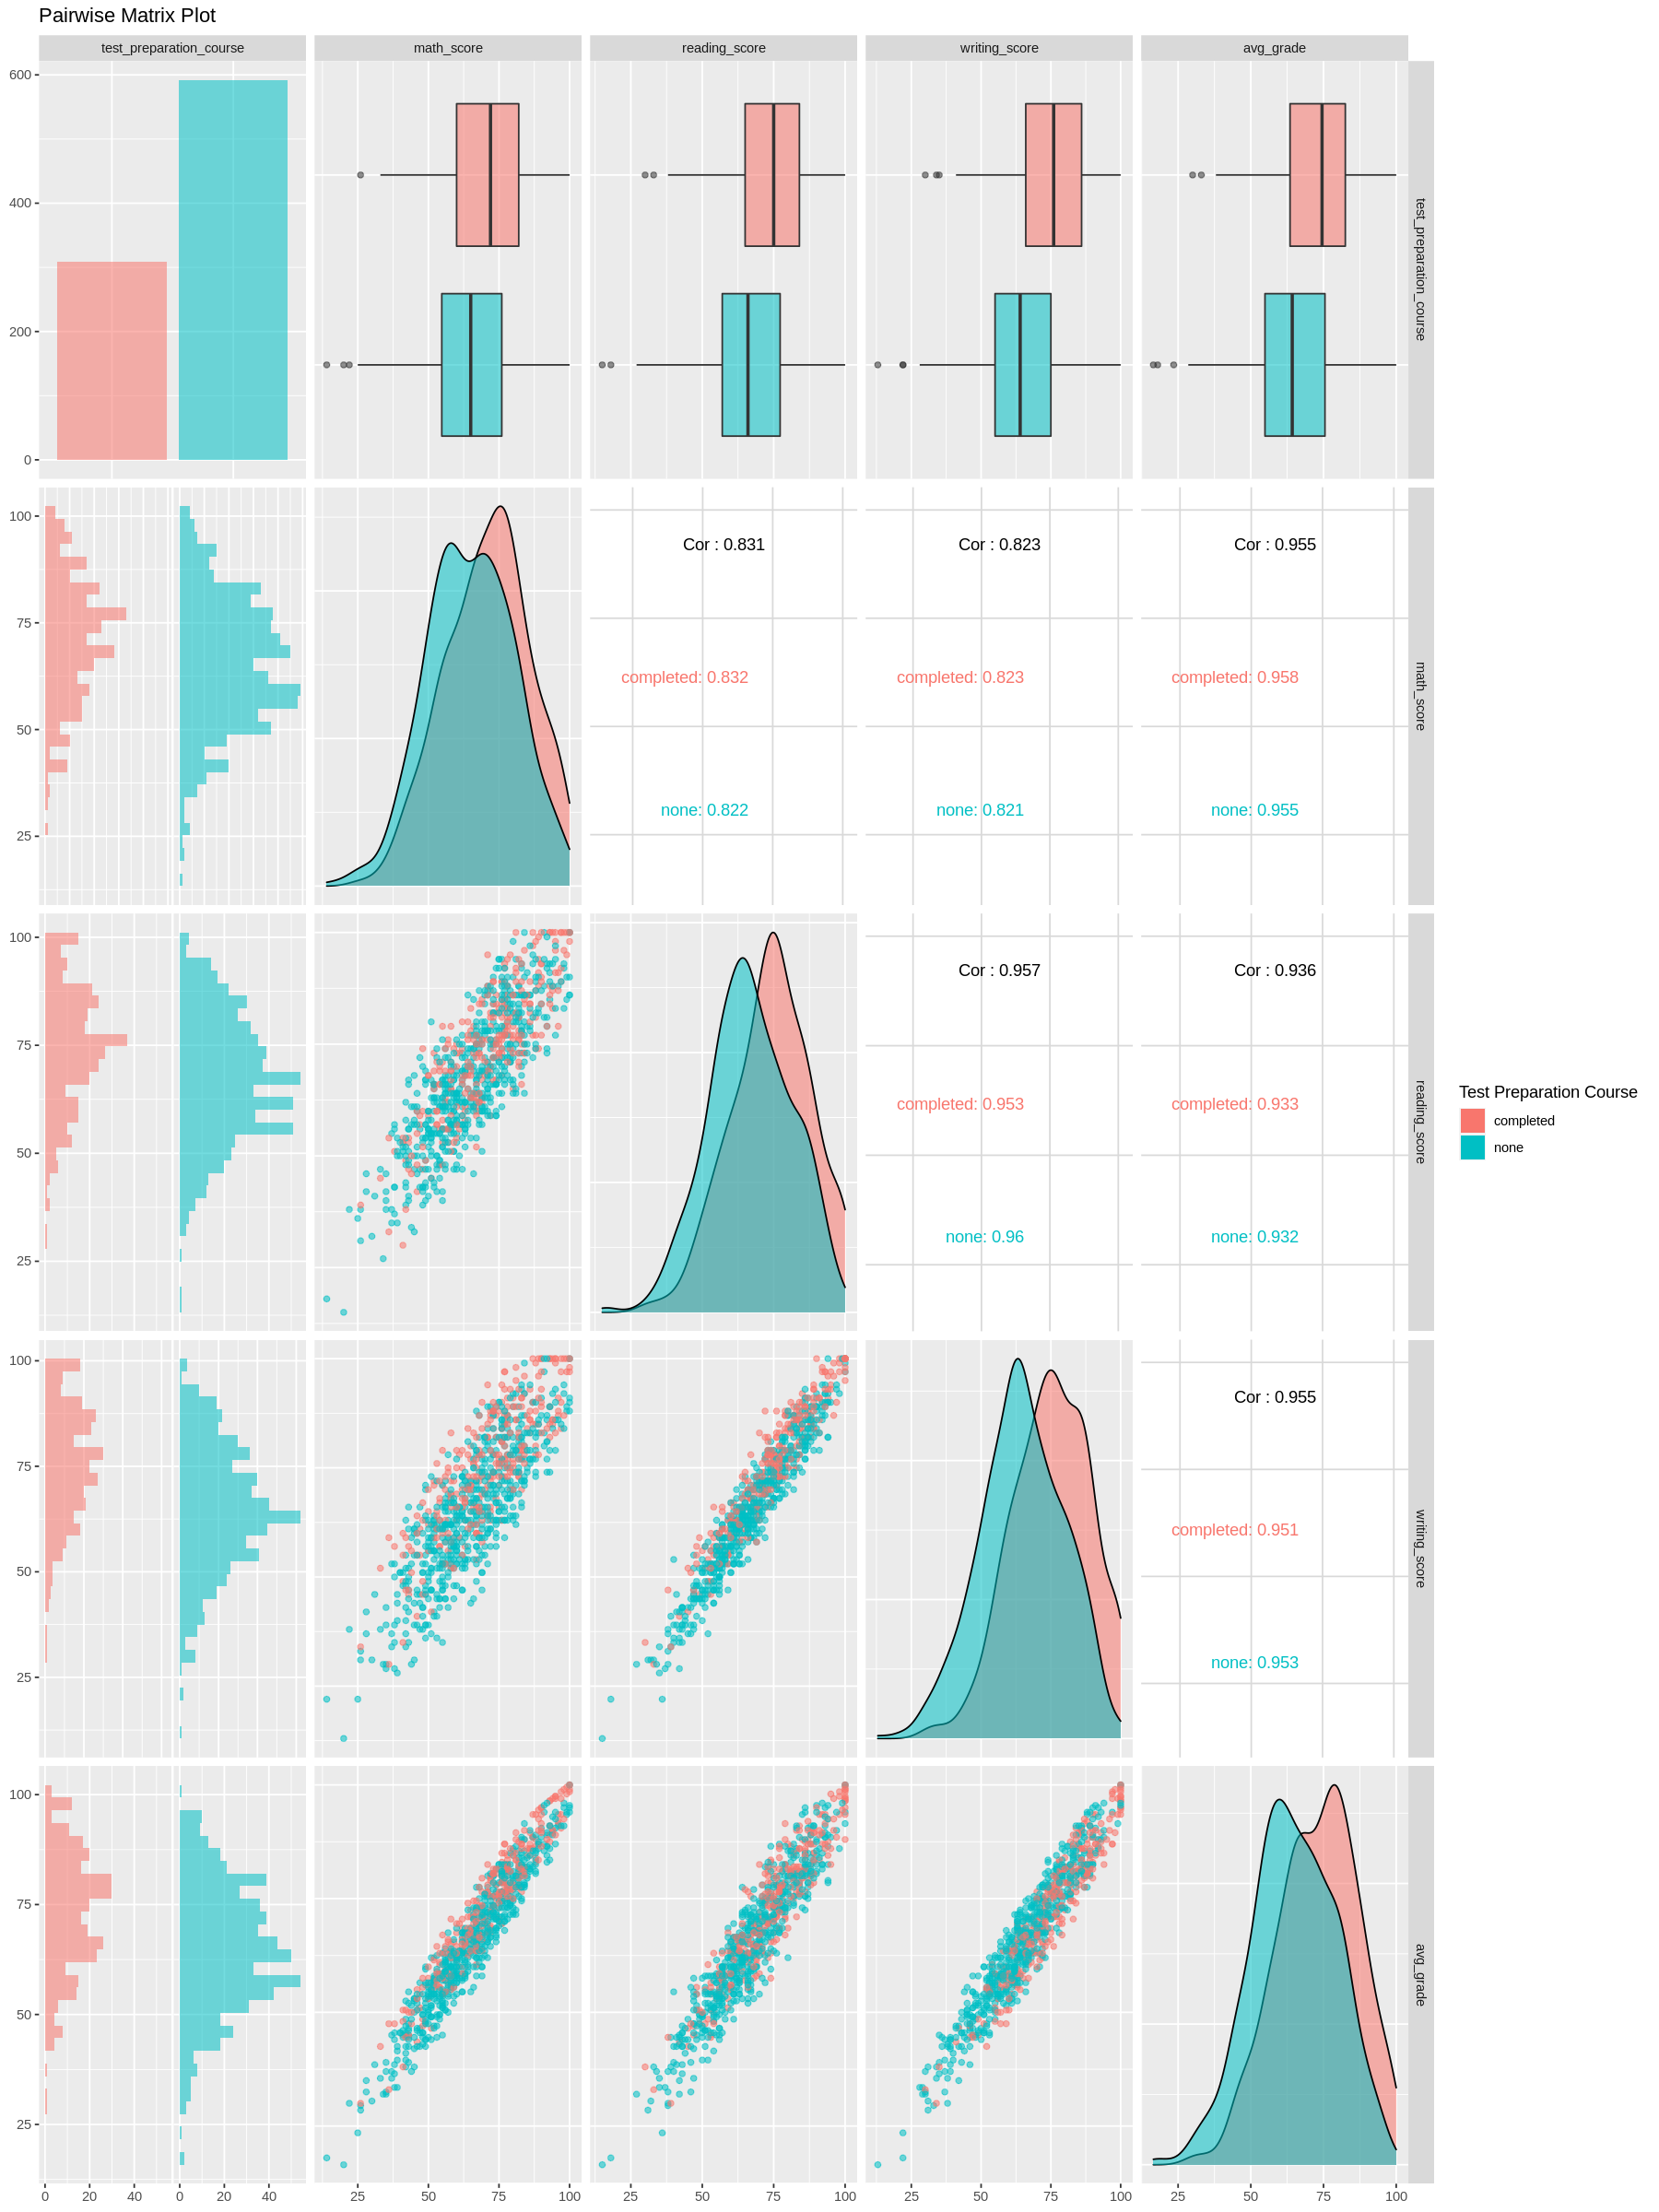

In [31]:
options(repr.plot.width = 15, repr.plot.height = 20) 
predictor_plots <-ggplot(exam_train, aes(x=test_preparation_course, fill=test_preparation_course))+
geom_bar()+
labs(fill="Test Preparation Course")+
ggtitle("Predictors Pairwise Matrix Plot")

bar_legend<-grab_legend(test_plot)

Pairwise_Matrix_legend<- ggpairs(exam_train, title = "Pairwise Matrix Plot", legend = bar_legend,
                           aes(alpha = 0.2, color = test_preparation_course))+
labs(fill="Test Preparation Course")
Pairwise_Matrix_legend

### Data Analysis - Performing KNN Classification

Science we have already spilte our data in second part, now will add a receip and also scale and center the data, pass the vector and the predictors to the recipe function.

To create our KNN classification model, we will

In [ ]:
exam_recipe <- recipe(test_preparation_course ~ ., data = exam_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
exam_recipe

In [ ]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_tune

In [ ]:
exam_vfold <- vfold_cv(exam_train, v = 10, strata = test_preparation_course)
exam_vfold

In [ ]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20))
knn_results <- workflow() %>%
       add_recipe(exam_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = exam_vfold, grid = k_vals) %>%
       collect_metrics()
knn_results

In [ ]:
accuracies <- knn_results %>% 
       filter(.metric == "accuracy" )

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

In [ ]:
exam_vfold_5 <- vfold_cv(exam_train, v = 5, strata = test_preparation_course)
exam_vfold_5
k_vals <- tibble(neighbors = seq(from = 1, to = 20))
knn_results_5 <- workflow() %>%
       add_recipe(exam_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = exam_vfold_5, grid = k_vals) %>%
       collect_metrics()
knn_results

In [ ]:
accuracies <- knn_results_5 %>% 
       filter(.metric == "accuracy" )

accuracy_versus_k_5 <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k_5

### Visualization of the Data Analysis